In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read data
df = pd.read_csv('data-sets/air_passengers.csv')

# Create lagged features
for i in range(1, 3):
    df[f'lag_{i}'] = df['Passengers'].shift(i)

# Drop NA values
df.dropna(inplace=True)

# Define inputs and target
X = df[['lag_1', 'lag_2']].values
y = df['Passengers'].values


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # 0.2 x 0.8 = 0.16


In [2]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

class FeedForwardNetwork(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        return self.layer2(x)


In [3]:
from torch.utils.data import DataLoader, TensorDataset

class LightningModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())
    

logger = TensorBoardLogger('tb_logs', name='my_model')

# Preparing data loaders
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initializing model and training
model = FeedForwardNetwork(input_size=2, hidden_size=100)
lightning_model = LightningModel(model)

trainer = pl.Trainer(max_epochs=100, logger=logger)
trainer.fit(lightning_model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\cemer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

  | Name  | Type               | Params
---------------------------------------------
0 | model | FeedForwardNetwork | 401   
1 | loss  | MSELoss            | 0     
---------------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)
C:\Users\cemer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\

Training: 0it [00:00, ?it/s]

C:\Users\cemer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\cemer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
`Trainer.fit` stopped: `max_epochs=100` reached.


tensor([[349.2845],
        [135.4655],
        [204.3748],
        [255.9411],
        [181.4934],
        [104.8655],
        [294.5428],
        [248.1513],
        [248.4705],
        [143.7527],
        [194.2366],
        [298.3822],
        [232.9812],
        [352.1775],
        [333.8319],
        [217.5755],
        [143.8758],
        [174.7247],
        [388.5903],
        [219.4247],
        [ 97.9830],
        [279.4461],
        [297.5405],
        [354.1609],
        [204.2142],
        [147.9340],
        [ 90.0790],
        [111.9109],
        [139.9981]], grad_fn=<AddmmBackward0>)


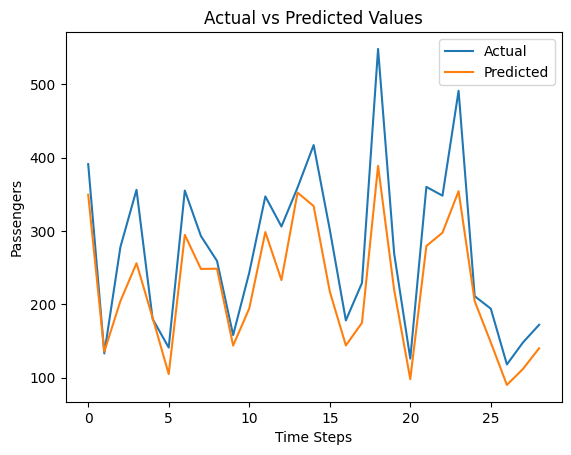

In [4]:
import matplotlib.pyplot as plt

# Predicting
lightning_model.eval()
predictions = lightning_model(torch.Tensor(X_test))

# Plotting
plt.plot(y_test, label='Actual')
plt.plot(predictions.detach().numpy(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Passengers')
plt.show()
